##############################################################################
##############################################################################
### **Atelier "Faire du Machine Learning et du Deep Learning sur des Time Series"**
##############################################################################
##############################################################################
<br>
<br>
<br>
<br>
#### **Partie 3 : Détection d'anomalies sur des séries temporelles et explicabilité sur ces anomalies**

<br>
<br>

Dans ce dernier notebook, nous allons utiliser la méthode de l'isolation forest pour détecter des anomalies sur nos time series. Nous allons aussi utiliser SHAP pour avoir des indices sur les caractéristiques qui expliquent le classement d'un sample en anomalie.

<br>
<br>
Nous allons ensuite utiliser un modèle LSTM pour avoir une explication quantitative sur les raisons des anomalies
<br>
<br>

## Section 0 : récupération, préparation et Fusion des Datasets ##

L'analyse multivariée repose sur l'intégration de variables exogènes (externes) pour améliorer la précision prédictive. Ici, nous fusionnons les données de consommation électrique avec les données météorologiques.

    Alignement temporel : Synchronisation des deux sources sur un index commun via une jointure interne (inner merge).

  

In [ ]:
import requests
import pandas as pd
import time

def fetch_brest_electricity_data():
    base_url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/json"
    
    # Paramètres de la requête
    params = {
        "where": "libelle_metropole='Brest Métropole' AND date_heure >= '2020-01-01' AND date_heure <= '2025-12-31'",
        "order_by": "date_heure ASC",
        "timezone": "UTC"
    }
    
    print("Récupération des données pour Brest Métropole (2020-2025)...")
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        data = response.json()
        df = pd.DataFrame(data)
        print(df.head())
            
        df = df[['date_heure', 'consommation']].dropna()
        
        print(f"Chargement Terminé ! {len(df)} lignes récupérées.")
        return df

    except Exception as e:
        print(f"Erreur lors de la récupération : {e}")
        return None


df_conso_brest = fetch_brest_electricity_data()

if df_conso_brest is not None:
    print(df_conso_brest.head())
    # Sauvegarde pour l'atelier
    df_conso_brest.to_csv("conso_brest_2020_2025.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# 1. indexation temporelle
df_conso_brest = df_conso_brest.rename(columns={"date_heure": "date"})
df_conso_brest['date'] = pd.to_datetime(df_conso_brest['date'], utc=True)
df_conso_brest = df_conso_brest.set_index('date').sort_index()

# changement de temporalité des données
df_conso_brest_journ = df_conso_brest['consommation'].resample('D').mean().interpolate()




In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Configuration de l'API avec cache et relance automatique en cas d'erreur
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_weather_data_brest(start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 48.3904, # Brest
        "longitude": -4.4861,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "shortwave_radiation"],
        "timezone": "Europe/Berlin"
    }
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Processus de transformation des données horaires
    hourly = response.Hourly()
    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    
    hourly_data["temp_moy"] = hourly.Variables(0).ValuesAsNumpy()
    hourly_data["humidity"] = hourly.Variables(1).ValuesAsNumpy()
    hourly_data["vent_vitesse"] = hourly.Variables(2).ValuesAsNumpy()
    hourly_data["rayonnement_moyen"] = hourly.Variables(3).ValuesAsNumpy()

    df_meteo = pd.DataFrame(data=hourly_data)
    
    # Passage en format journalier
    df_meteo_journ = df_meteo.resample('D', on='date').mean()
    
    return df_meteo_journ


df_meteo_brest_journ = get_weather_data_brest("2020-01-01", "2025-12-31")
print(df_meteo_brest_journ.head())

In [ ]:
# 2. Fusion (Jointure sur la date)

df_data_multi_brest = pd.merge(df_conso_brest_journ, df_meteo_brest_journ, on='date', how='inner')

print(df_data_multi_brest.head())



## Section 1 : Ingénierie des caractéristiques ##

Nous allons aider le modèle en construisant des caractéristiques reflétant la position du chargé de prédiction le jour j.


In [ ]:
# --- PASSÉ (Lags) ---
# Consommation de la veille (J-1), de l'avant veille (J-2) et de la semaine dernière (J-7) pour la saisonnalité
df_data_multi_brest['conso_obs_j-1'] = df_data_multi_brest['consommation'].shift(1)
df_data_multi_brest['conso_obs_j-2'] = df_data_multi_brest['consommation'].shift(2)
df_data_multi_brest['conso_obs_j-7'] = df_data_multi_brest['consommation'].shift(7)

# Météo observée hier (J-1) pour l'inertie thermique
df_data_multi_brest['temp_obs_j-1'] = df_data_multi_brest['temp_moy'].shift(1)

# Météo observée hier (J-1) pour l'humidité
df_data_multi_brest['humidity_j-1'] = df_data_multi_brest['humidity'].shift(1)

# Météo observée hier (J-1) pour le rayonnement
df_data_multi_brest['rayonnement_moyen_j-1'] = df_data_multi_brest['rayonnement_moyen'].shift(1)

# Météo observée hier (J-1) pour le vent
df_data_multi_brest['vent_vitesse_j-1'] = df_data_multi_brest['vent_vitesse'].shift(1)

# --- FUTUR / PRÉVISIONS (Leads) ---
# On utilise la donnée réelle de J comme si c'était la prévision faite le matin même
df_data_multi_brest['temp_prev_j'] = df_data_multi_brest['temp_moy'] 

# On utilise la donnée de J+1 comme prévision pour demain (Lead)
df_data_multi_brest['temp_prev_j+1'] = df_data_multi_brest['temp_moy'].shift(-1)


df_data_multi_brest = df_data_multi_brest.dropna()

print(df_data_multi_brest.head())


# Définition des périodes
dataset_train = df_data_multi_brest['2015-01-01':'2024-12-31']
dataset_test = df_data_multi_brest['2025-01-01':'2025-12-31']




In [ ]:
import holidays

# On définit les jours fériés en France 
fr_holidays = holidays.France()

def add_calendar_features(df):
    # On travaille sur une copie pour ne pas modifier l'original par mégarde
    df_enriched = df.copy()
    
    # 1. Variables temporelles basiques
    df_enriched['day_of_week'] = df_enriched.index.dayofweek
    df_enriched['month'] = df_enriched.index.month
    df_enriched['is_weekend'] = df_enriched.index.dayofweek.isin([5, 6]).astype(int)
    
    # 2. Jours fériés (Boolean : 1 si férié, 0 sinon)
    df_enriched['is_holiday'] = df_enriched.index.map(lambda x: 1 if x in fr_holidays else 0)
    
    # 3.  Veille et Lendemain de jour férié 
    df_enriched['is_holiday_prev'] = df_enriched['is_holiday'].shift(-1, fill_value=0)
    df_enriched['is_holiday_next'] = df_enriched['is_holiday'].shift(1, fill_value=0)
    
    return df_enriched

# Application sur vos datasets
dataset_train_enriched = add_calendar_features(dataset_train)
dataset_test_enriched = add_calendar_features(dataset_test)

print(dataset_test_enriched.head())

## Section 2 : Détection des anomalies sur la consommation électrique de 2025 à Brest ##

Nous allons maintenant utiliser la méthode de la forêt isolée pour détecter les anomalies de consommation.
<br><br>
L'idée sous-jacente de cette approche est de mesurer pour chaque échantillon combien de profondeur d'arbre de décision faut-il pour l'isoler de toute le reste du dataset. 
<br><br>
L'idée : si cette profondeur est faible, ce sample est facilement séparable, il est une anomalie

In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# 1. Nettoyage des données
train_clean = dataset_train_enriched.dropna()
test_clean = dataset_test_enriched.dropna()

# 2. Initialisation du modèle
# n_estimators : nombre d'arbres 
# contamination : proportion estimée d'anomalies, sert à choisir le treshold détectant les anomalies 
model_if = IsolationForest(n_estimators=100, 
                           contamination=0.01)

# 3. Entraînement de la foret sur le dataset d'entrainement
#######################################
#ligne à remplir
#######################################
model_if.fit()

# 4. prédictions
#######################################
#ligne à remplir
#######################################
predictions = model_if.predict()


test_clean['is_anomaly'] = predictions

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Tracer la consommation réelle
plt.plot(test_clean.index, test_clean['consommation'], color='blue', alpha=0.4, label='Consommation')

# Identifier les anomalies
#######################################
#ligne à remplir
#######################################
anomalies = test_clean[]

# Superposer les points rouges
plt.scatter(anomalies.index, anomalies['consommation'], color='red', label='Anomalie Détectée')

plt.title('Détection d\'événements rares via Isolation Forest')
plt.legend()
plt.show()

<br><br>

Nous avons bien détecté des anomalies en 2025. A vous de jouer, explorer ces anomalies et comprenez à quels jours particuliers de l'année sont-ils associés.

<br><br>

Cette analyse est intéressante, car nous comprendons rapidement la rareté évènementielle, mais qu'en est-il des paramètres qui expliquent ces anomalies é est-ce des facteurs météo ou bien des facteurs calendaires ?

<br><br>

## Section 3 d'explicabilité : Montrer pourquoi une anomalie est une anomalie ##

In [ ]:
import shap
import numpy as np

# On s'assure que les données passées à SHAP sont des valeurs pures (numpy) 
# pour éviter les conflits de noms de colonnes ou d'index de Pandas
features_cols = train_clean.columns.tolist()
X_reference = train_clean[features_cols].values
X_anomaly = test_clean[test_clean['is_anomaly'] == -1][features_cols].values
print(test_clean[test_clean['is_anomaly'] == -1][features_cols])
print(X_anomaly[0:1])


# 1. Initialisation de l'explainer avec le modèle déjà entraîné
# On utilise un échantillon du train pour la baseline
explainer = shap.TreeExplainer(model_if, data=X_reference[:100])

# 2. Calcul des SHAP values pour la première anomalie détectée
#######################################
#ligne à remplir
#######################################
shap_values_single = explainer.shap_values()

# 3. Visualisation
shap.force_plot(
    explainer.expected_value, 
    shap_values_single[0], 
    features=X_anomaly[0:1],
    #######################################
    #ligne à remplir
    ####################################### 
    feature_names=,
    matplotlib=True
)



<br><br>
La visualisation n'est pas satisfaisante, on va plutot utiliser l'affichage en cascade
<br><br>

In [ ]:

explainer = shap.Explainer(model_if, train_clean)
shap_values = explainer(test_clean[features_cols])

# 2. On sélectionne l'index d'une anomalie détectée (ex: la première)
#######################################
#ligne à remplir
#######################################
anomalie_idx = test_clean[].index[0]
# On récupère sa position entière dans le tableau pour SHAP
loc_idx = test_clean.index.get_loc(anomalie_idx)

# 3. Affichage en "Waterfall" (Cascade)
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[loc_idx], max_display=15)

<br><br>
A vous de jouer, expliquer pour chaque anomalie quels sont les facteurs prépondérants expliquant la surconsommation ou la sous-consommation. Est-ce cohérent à votre avis é
<br><br>

## Section 3 : Expression quantitative des anomalies par modélisation LTSM ##

Nous allons maintenant essayer de modéliser les anomalies, et si c'est un succès, d'expliquer quantitativement pourquoi la consommation réélle est une anomalie
<br><br>
L'idée sous-jacente de cette approche de considerer la modélisation LSTM comme un proxy pour détecter quels features ont influer sur l'atypie de la consommation réelle


### Section 3.1 : Création du LSTM  ##



In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Normalisation
scaler_uni = MinMaxScaler(feature_range=(0, 1))
scaler_multi_x = MinMaxScaler(feature_range=(0, 1))
scaler_multi_y = MinMaxScaler(feature_range=(0, 1))




In [ ]:

# Sélection des colonnes pour le modèle
features = [
    'conso_obs_j-1','conso_obs_j-2', 'conso_obs_j-7', 
    'temp_moy',   'humidity',  'vent_vitesse', 'rayonnement_moyen',
    'temp_obs_j-1',  'humidity_j-1', 'rayonnement_moyen_j-1', 'rayonnement_moyen_j-1','vent_vitesse_j-1',
    'temp_prev_j',  'temp_prev_j+1',
    'day_of_week','month','is_weekend','is_holiday','is_holiday_prev','is_holiday_next'
]
target = 'consommation'

X_train_multi = dataset_train_enriched[features].values
y_train_multi = dataset_train_enriched[target].values

X_test_multi = dataset_test_enriched[features].values
y_test_multi = dataset_test_enriched[target].values

X_train_multi_scaled = scaler_multi_x.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi_x.transform(X_test_multi)
y_train_multi_scaled = scaler_multi_y.fit_transform(y_train_multi.reshape(-1, 1))
y_test_multi_scaled = scaler_multi_y.transform(y_test_multi.reshape(-1, 1))




def create_sequences_for_multivariate(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        # On prend une fenêtre de 'window_size' jours pour X
        X_seq.append(X[i-window_size:i])
        # La cible est la valeur de y juste après cette fenêtre
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Configuration de la fenêtre : on regarde les 7 derniers jours
window_size = 30 

X_train_multi_scaled_seq, y_train_multi_scaled_seq = create_sequences_for_multivariate(X_train_multi_scaled, y_train_multi_scaled, window_size)
X_test_multi_scaled_seq, y_test_multi_scaled_seq = create_sequences_for_multivariate(X_test_multi_scaled, y_test_multi_scaled, window_size)


print(f"Forme de dataset_train : {dataset_train.shape}")
print(f"Forme de dataset_test : {dataset_test.shape}") 

print(f"Forme de X_train_scaled_multi : {X_train_multi.shape}")
print(f"Forme de y_train_scaled_multi : {y_train_multi.shape}")


print(f"Forme de X_train_multi : {X_train_multi.shape}")
print(f"Forme de y_train_multi : {y_train_multi.shape}") 
print(f"Forme de X_test_multi : {X_test_multi.shape}")
print(f"Forme de y_test_multi : {y_test_multi.shape}") 

print(f"Forme de X_train_multi_scaled_seq : {X_train_multi_scaled_seq.shape}") 

Forme de dataset_train : (1820, 14)
Forme de dataset_test : (364, 14)
Forme de X_train_scaled_multi : (1820, 20)
Forme de y_train_scaled_multi : (1820,)
Forme de X_train_multi : (1820, 20)
Forme de y_train_multi : (1820,)
Forme de X_test_multi : (364, 20)
Forme de y_test_multi : (364,)
Forme de X_train_multi_scaled_seq : (1790, 30, 20)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Initialisation du modèle
model_lstm_multi = Sequential([
   
    # input_shape = (nb_pas_de_temps, nb_features)
    LSTM(50, activation='relu', input_shape=(window_size, X_train_multi_scaled_seq.shape[2]), return_sequences=False),
    
    
    # Dropout pour éviter le sur-apprentissage (overfitting)
    Dropout(0.2),
    
    # Couche Dense intermédiaire pour affiner les patterns
    Dense(32, activation='relu'),
    
    # Couche de sortie : 1 neurone pour la prédiction finale (valeur continue)
    Dense(1)
])

# Compilation
model_lstm_multi.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# 3. Entraînement
# epochs : nombre de passages sur les données
# batch_size : nombre d'échantillons traités avant la mise à jour des poids
history = model_lstm_multi.fit(
    #X_train_multi_scaled_seq[:,:,0], y_train_multi_scaled_seq, 
    X_train_multi_scaled_seq,y_train_multi_scaled_seq,
    epochs=1000, 
    batch_size=32, 
    validation_split=0.1, # On garde 10% pour valider pendant l'entraînement
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/1000


c:\Code_ML\Code\Atelier Time Series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0199 - val_loss: 0.0071
Epoch 2/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0064
Epoch 3/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 4/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 6/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 7/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 8/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 9/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 10/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 11/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 12/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [ ]:
# 1. Faire les prédictions sur le jeu de test
predictions_scaled = model_lstm_multi.predict(X_test_multi_scaled_seq)

# 2. Inverser la normalisation pour les prédictions et pour les vraies valeurs
y_pred = scaler_multi_y.inverse_transform(predictions_scaled)
y_actual = scaler_multi_y.inverse_transform(y_test_multi_scaled_seq)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


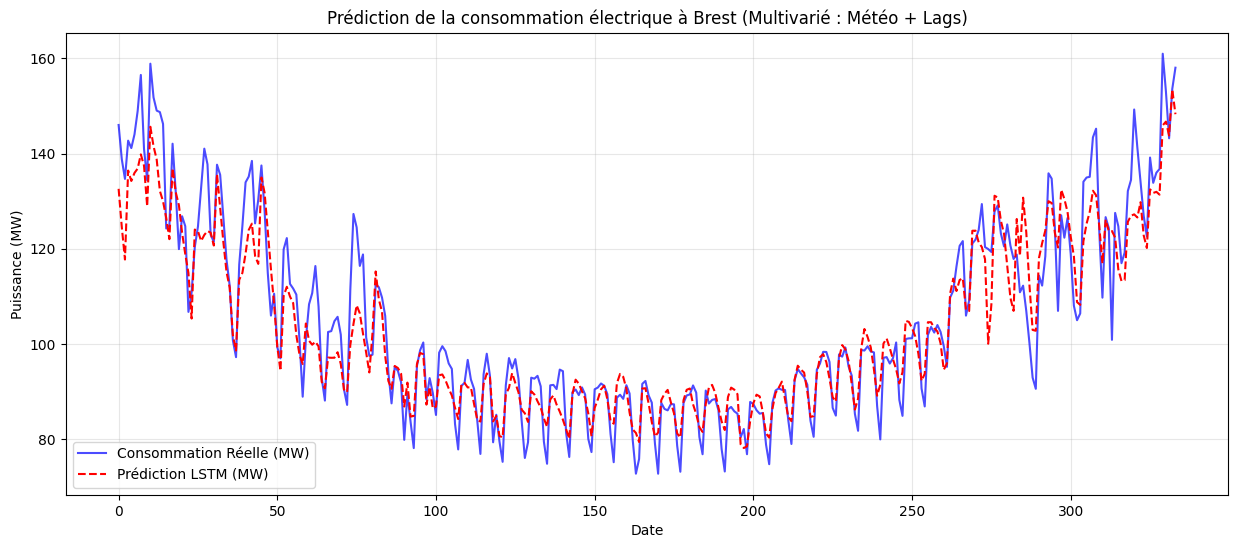

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Consommation Réelle (MW)', color='blue', alpha=0.7)
plt.plot(y_pred, label='Prédiction LSTM (MW)', color='red', linestyle='--')

plt.title('Prédiction de la consommation électrique à Brest (Multivarié : Météo + Lags)')
plt.xlabel('Date')
plt.ylabel('Puissance (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Section 2.2 Explicabilité quantitatibe de la détection d'anomalies (LSTM)


- SHAP permet d'expliquer **pourquoi** le modéle a produit une prédiction élevée ou faible, qui représente notre anomalie : chaque variable (et chaque pas de temps) reéoit une contribution vers la sortie.

- Le `background` représente des séquences normales ; SHAP compare l'exemple à cette référence.

- On agrége ensuite les contributions sur les pas de temps pour obtenir une importance globale par variable, puis on repasse en MW.


Forme du background : (50, 30, 20)
Anomalie cible: 2025-07-12 00:00:00+00:00 | consommation reelle IF: 79.75 MW
Position brute: 192 | position sequence LSTM: 162


100%|██████████| 1/1 [00:12<00:00, 12.09s/it]


y_test min reel: 72.73 MW
base_value_mw: 103.32 MW | predicted_mw: 80.73 MW


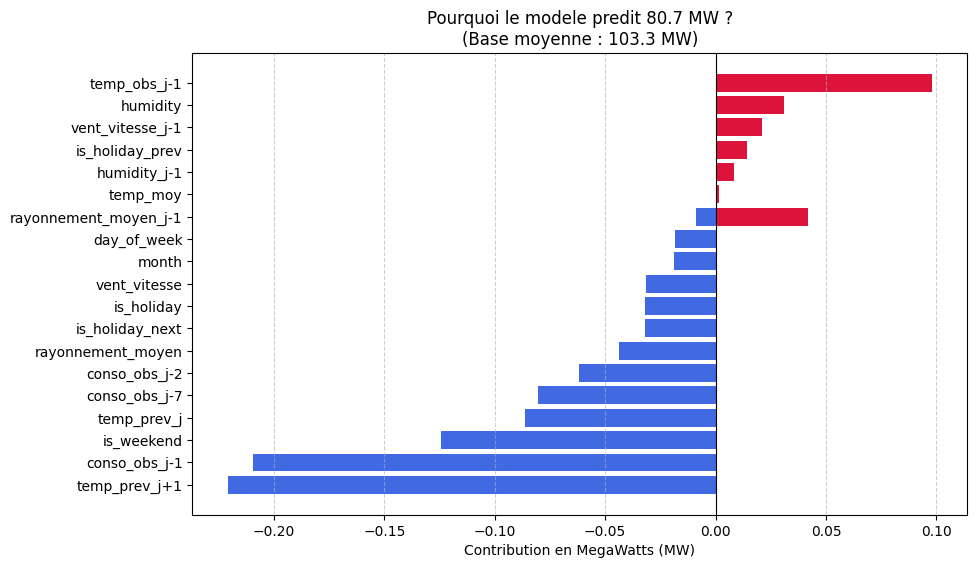

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def to_numpy(x):
    if isinstance(x, tf.data.Dataset):
        # Empile les batches (X ou (X,y)) en un seul tableau
        xs = []
        for batch in x:
            xb = batch[0] if isinstance(batch, (tuple, list)) else batch
            xs.append(xb.numpy())
        return np.concatenate(xs, axis=0)
    return x.values if hasattr(x, 'values') else np.asarray(x)

# 1. Background de sequences normales (echantillon du train)
X_train_np = to_numpy(X_train_multi_scaled_seq)
X_test_np = to_numpy(X_test_multi_scaled_seq)

n_samples = 150 #X_train_np.shape[0]
rng = np.random.default_rng(42)
#######################################
#ligne à remplir : trouvez comment choix n_samples indices aléatoirement parmi X_Train_np à l'aide de rng
#######################################
indices = rng.choice()
background = X_train_np[indices]
print(f"Forme du background : {background.shape}")  # (n_samples, n_steps, n_features)


# 2. Création du background pour avoir le comportement normal
# On aplatit les sequences pour le KernelExplainer
n_steps = X_train_np.shape[1]
n_features = X_train_np.shape[2]

def predict_flat(x_flat):
    x_seq = x_flat.reshape((-1, n_steps, n_features))
    return model_lstm_multi.predict(x_seq, verbose=0)

background_flat = background.reshape((background.shape[0], -1))
explainer = shap.KernelExplainer(predict_flat, background_flat)


# 3. Selection  de la 1ere anomalie trouvée par la méthode de Isolation Forest
anomalies_if = test_clean[test_clean['is_anomaly'] == -1]
target_anomaly_idx = anomalies_if.index[0]
target_anomaly_mw = float(anomalies_if.iloc[0]['consommation'])

# Pour chercher l'anomalie dans les séquences multivariée, on va passer par l'index temporel, puis décaler de window_size pour avoir la séquence
if target_anomaly_idx not in dataset_test_enriched.index:
    raise ValueError("L'index de l'anomalie n'existe pas dans dataset_test_enriched.")

raw_pos = dataset_test_enriched.index.get_loc(target_anomaly_idx)
loc_idx = raw_pos - window_size
if loc_idx < 0 or loc_idx >= X_test_np.shape[0]:
    raise ValueError(
        f"Index sequence hors bornes: raw_pos={raw_pos}, window_size={window_size}, loc_idx={loc_idx}."
    )

sample = X_test_np[loc_idx:loc_idx+1]
sample_flat = sample.reshape((1, -1))
n_flat = sample_flat.shape[1]

print(f"Anomalie cible: {target_anomaly_idx} | consommation reelle IF: {target_anomaly_mw:.2f} MW")


# 4. explication de l'échantillon décrivant l'anomalie
shap_values = explainer.shap_values(
    sample_flat,
    nsamples=max(2 * n_flat, 200),
    l1_reg=0
)
if isinstance(shap_values, list):
    shap_values = shap_values[0]  

# 5. Mise en forme des SHAP values
shap_values = shap_values.reshape((1, n_steps, n_features))
shap_aggregated = shap_values.mean(axis=1).ravel()


expected_value = explainer.expected_value
if isinstance(expected_value, (list, tuple, np.ndarray)):
    expected_value = np.array(expected_value).ravel()[0]

# 6. récupération de la prédiction du LSTM
pred_scaled = float(model_lstm_multi.predict(sample, verbose=0).ravel()[0])

# Dénormalisation
base_value_mw = scaler_multi_y.inverse_transform([[expected_value]])[0, 0]
predicted_mw = scaler_multi_y.inverse_transform([[pred_scaled]])[0, 0]

# 7. Conversion des contributions SHAP en MW
coef_mw_per_scaled = (
    scaler_multi_y.inverse_transform([[1.0]])[0, 0]
    - scaler_multi_y.inverse_transform([[0.0]])[0, 0]
)
#######################################
#ligne à remplir : trouvez les éléments à multiplier entre eux pour trouver la valeur de SHAP en MW
#######################################
shap_mw =  * 


print(f"Valeur de base de consommation attendue: {base_value_mw:.2f} MW | Valeur de consommation prédite par le LSTM: {predicted_mw:.2f} MW")



In [ ]:
impact_df = pd.DataFrame({
    'Feature': features,
    'Impact_MW': shap_mw
}).sort_values(by='Impact_MW')

plt.figure(figsize=(10, 6))
colors = ['crimson' if x > 0 else 'royalblue' for x in impact_df['Impact_MW']]
plt.barh(impact_df['Feature'], impact_df['Impact_MW'], color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title(
    f"Pourquoi le modele predit {predicted_mw:.1f} MW ?\n"
    f"(Base moyenne : {base_value_mw:.1f} MW)"
)
plt.xlabel('Contribution en MegaWatts (MW)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Lors du 2025-07-12, la consommation réelle est 79.75 MW et le LSTM prédit 80.73 MW.
<br><br>
Le graphique SHAP s’interprète donc comme la décomposition des facteurs qui ont poussé la prédiction vers un niveau bas, ce qui est ici une bonne approximation des facteurs de la valeur réelle.
<br>
En parallèle, l’Isolation Forest classe ce point en anomalie car la combinaison des variables est rare par rapport au comportement habituel, même si elle reste explicable par le modèle de régression.
<br><br>
Conclusion : cette anomalie au sens “atypique”, mais pas au sens “incompréhensible”, puisque la baisse est bien capturée par le LSTM et cohérente avec les variables explicatives.


<br><br>
<br><br>
A vous de jouer, explorer les autres anomlies et essayez d'interpréter les autres anomalies!